Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from glob import glob

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/DL_assignment/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/DL_assignment/CNN_assignment.zip"

Archive:  /content/gdrive/MyDrive/DL_assignment/CNN_assignment.zip
replace Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing



### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
imag_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:

## Creating train dataset
train_ds=tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train,labels="inferred",image_size=(180,180),seed=123,label_mode="categorical",validation_split=0.2,subset="training")

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
#Create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train,labels="inferred",image_size=(180,180),seed=123,label_mode="categorical",validation_split=0.2,subset="validation")

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Visualize one instance of all the nine classes present in the dataset

In [10]:
import matplotlib.pyplot as plt

image_dir_path =[]
for c in class_names:
    # extract path of class directory
    
    img01_dir_list = os.listdir(str(data_dir_train)+'/'+c)
    # select a random image from all the images in class
    num=np.random.randint(len(img01_dir_list))
    img01_dir_name=img01_dir_list[num]
    # append the image name to get the directory path to image
    img01_dir_path = str(data_dir_train)+'/'+c+'/' + img01_dir_name
    image_dir_path.append(img01_dir_path)

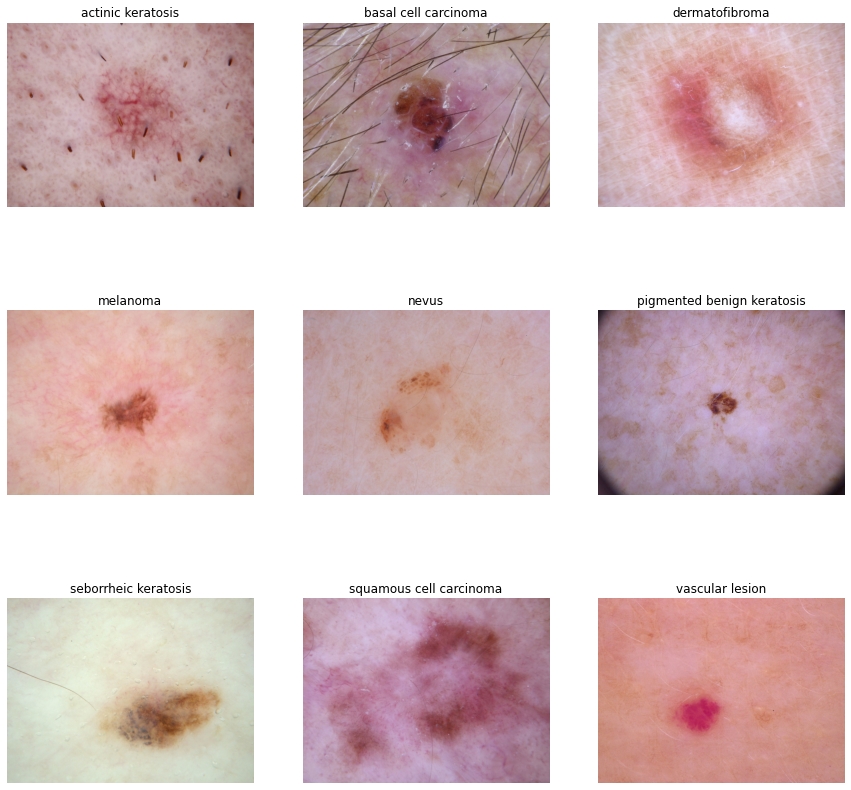

In [11]:
# Visualize random image from each class
index=0
imgnum=0
plt.figure(figsize=(15,15))
for c in class_names:
  index=index+1
  plt.subplot(3,3,index)
  plt.imshow(load_img(image_dir_path[imgnum]))
  plt.title(c)
  plt.axis('off')
  imgnum=imgnum+1



The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [13]:
### Create initial model
model=keras.Sequential([
        keras.layers.experimental.preprocessing.Rescaling (1./255,input_shape=(180,180,3)),           
        keras.layers.Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=(180,180,3)),
        keras.layers.Conv2D(32,kernel_size=(3,3),activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
        keras.layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(512,activation="relu"),
    keras.layers.Dense(len(class_names),activation="softmax"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 84, 84, 64)        36928     
                                                        

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 84, 84, 64)        36928     
                                                        

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 29s 131ms/step - loss: 2.3499 - accuracy: 0.2958 - val_loss: 1.6887 - val_accuracy: 0.4161
Epoch 2/20
56/56 [==============================] - 5s 81ms/step - loss: 1.5443 - accuracy: 0.4604 - val_loss: 1.4505 - val_accuracy: 0.5101
Epoch 3/20
56/56 [==============================] - 4s 80ms/step - loss: 1.4628 - accuracy: 0.4939 - val_loss: 1.4336 - val_accuracy: 0.5101
Epoch 4/20
56/56 [==============================] - 4s 80ms/step - loss: 1.3538 - accuracy: 0.5290 - val_loss: 1.4672 - val_accuracy: 0.5078
Epoch 5/20
56/56 [==============================] - 4s 80ms/step - loss: 1.3027 - accuracy: 0.5513 - val_loss: 1.4343 - val_accuracy: 0.5011
Epoch 6/20
56/56 [==============================] - 5s 81ms/step - loss: 1.2099 - accuracy: 0.5675 - val_loss: 1.6520 - val_accuracy: 0.4899
Epoch 7/20
56/56 [==============================] - 5s 81ms/step - loss: 1.1362 - accuracy: 0.5949 - val_loss: 1.4353 - val_accuracy: 0.5145
Epoch 8/20


### Visualizing training results

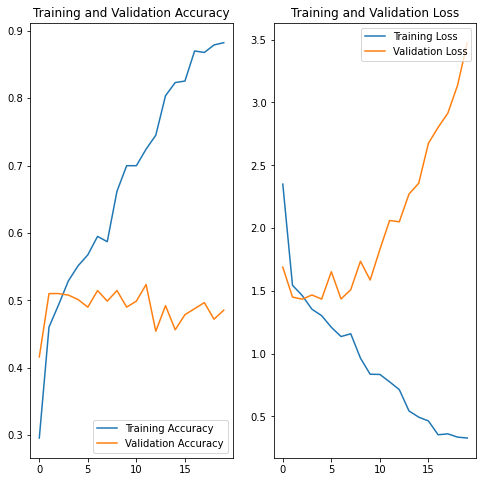

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

 As we can see from the plots model is hugely overfitting

### Data Augmentation

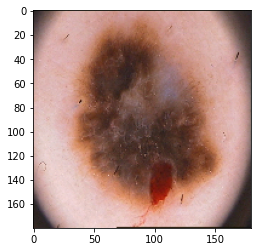

In [18]:
# Plot how the image look for one instance of training data
image, label = next(iter(train_ds))
plt.imshow(image[0].numpy().astype("uint8"))

In [19]:
# Select an augmetation stratergy, random flip and random rotation
image_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.3),
])

In [20]:
image = tf.cast(tf.expand_dims(image, 0), tf.float32)


### Create the model, compile and train the model


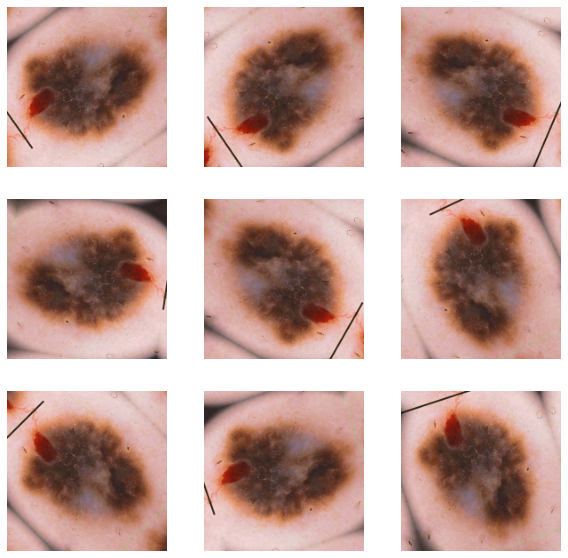

In [21]:
#Visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = image_augmentation(image[0])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

In [22]:
# Since there is evidence of overfitting use dropout layers 
model2=keras.Sequential([
        keras.layers.experimental.preprocessing.Rescaling (1./255,input_shape=(180,180,3)),  
        image_augmentation,         
        keras.layers.Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=(180,180,3)),
        keras.layers.Conv2D(32,kernel_size=(3,3),activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.Dropout(0.5),
        keras.layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
        keras.layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.Dropout(0.25),
        keras.layers.Flatten(),
        keras.layers.Dense(512,activation="relu"),
        keras.layers.Dropout(0.25),
    keras.layers.Dense(len(class_names),activation="softmax"),
])


### Compiling the model

In [23]:
## Compile the model
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Training the model

In [24]:
## train your model for 20 epochs
history = model2.fit(train_ds,
              batch_size=32,
              epochs=20,
              validation_data=val_ds,
              shuffle=True)

Epoch 1/20
56/56 [==============================] - 6s 88ms/step - loss: 2.5442 - accuracy: 0.1568 - val_loss: 2.0808 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 5s 85ms/step - loss: 2.0205 - accuracy: 0.2059 - val_loss: 1.9244 - val_accuracy: 0.2103
Epoch 3/20
56/56 [==============================] - 5s 86ms/step - loss: 1.9140 - accuracy: 0.2718 - val_loss: 1.7944 - val_accuracy: 0.2931
Epoch 4/20
56/56 [==============================] - 5s 86ms/step - loss: 1.7880 - accuracy: 0.3482 - val_loss: 1.7158 - val_accuracy: 0.3960
Epoch 5/20
56/56 [==============================] - 5s 85ms/step - loss: 1.8320 - accuracy: 0.3348 - val_loss: 1.8102 - val_accuracy: 0.3356
Epoch 6/20
56/56 [==============================] - 5s 85ms/step - loss: 1.8254 - accuracy: 0.3008 - val_loss: 1.7388 - val_accuracy: 0.3356
Epoch 7/20
56/56 [==============================] - 5s 86ms/step - loss: 1.7273 - accuracy: 0.3616 - val_loss: 1.6339 - val_accuracy: 0.4452
Epoch 8/20
56

### Visualizing the results

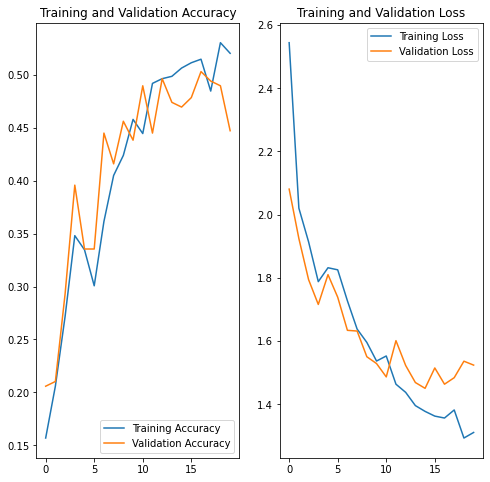

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### It is seen clearly from graph that overfitting is reduced due to droputs and data augmentation  introduced but accuracy is low.

####  Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
## Your code goes here.
# No. of images in each class
image_dir_path =[]
for c in class_names:
    # extract name of random image  in each class directory
    
    img01_dir_list = os.listdir(str(data_dir_train)+'/'+c)
    num=(len(img01_dir_list))
    print(c,num)

actinic keratosis 114
basal cell carcinoma 376
dermatofibroma 95
melanoma 438
nevus 357
pigmented benign keratosis 462
seborrheic keratosis 77
squamous cell carcinoma 181
vascular lesion 139


#### Findings
#### - seborrheic keratosis has the least number of samples
#### - pigmented benign keratosis class dominate the data in terms proportionate number of samples?


####  Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDB860B6D90>: 100%|██████████| 500/500 [00:18<00:00, 27.35 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDB6E10DF90>: 100%|██████████| 500/500 [00:19<00:00, 25.60 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDB860A7C90>: 100%|██████████| 500/500 [00:20<00:00, 24.96 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FDC02B29F10>: 100%|██████████| 500/500 [01:44<00:00,  4.79 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FDB6E172AD0>: 100%|██████████| 500/500 [01:26<00:00,  5.80 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDB86116C50>: 100%|██████████| 500/500 [00:17<00:00, 28.65 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FDB6E0B2AD0>: 100%|██████████| 500/500 [00:41<00:00, 12.08 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDB6E18FA10>: 100%|██████████| 500/500 [00:16<00:00, 30.63 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDB8608F1D0>: 100%|██████████| 500/500 [00:16<00:00, 29.98 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010034.jpg_db2b85c7-9a40-4363-8bf1-03560fb61425.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011187.jpg_f0f7b6b0-5608-4b38-a7fd-9f86a52726e8.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000152.jpg_05c2e1ad-47a6-4d64-a501-3b81839f45f0.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010393.jpg_0d41e758-4f51-4127-96cc-4a4d9f97c771.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010942.jpg_cfb31162-b167-4463-a03d-70d3c6560c3f.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010630.jpg_40f94

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [32]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])


In [34]:
df2['Label'].value_counts()

melanoma                      500
actinic keratosis             500
nevus                         500
basal cell carcinoma          500
pigmented benign keratosis    500
seborrheic keratosis          500
dermatofibroma                500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [36]:
# Create train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',
  image_size=(180, 180),
  batch_size=32)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [37]:
#create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,label_mode='categorical',
  seed=123, subset = 'validation',
  validation_split = 0.2,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [43]:
## Create model
model3=keras.Sequential([
        keras.layers.experimental.preprocessing.Rescaling (1./255,input_shape=(180,180,3)),    
        image_augmentation,        
        keras.layers.Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=(180,180,3),padding="same"),
        keras.layers.Conv2D(32,kernel_size=(3,3),activation="relu",padding="same"),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.Dropout(0.1),
        
        keras.layers.Conv2D(64,kernel_size=(3,3),activation="relu",padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64,kernel_size=(3,3),activation="relu",padding="same"),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.Dropout(0.25),

        keras.layers.Conv2D(128,kernel_size=(3,3),activation="relu",padding="same"),
        keras.layers.Conv2D(128,kernel_size=(3,3),activation="relu",padding="same"),
        keras.layers.MaxPooling2D(pool_size=(2,2)),
        keras.layers.Dropout(0.5),
        keras.layers.Flatten(),
        keras.layers.Dense(128,activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(len(class_names),activation="softmax"),
])


####Compile your model (Choose optimizer and loss function appropriately)

In [44]:

model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [45]:
history =model3.fit(train_ds,
              batch_size=32,
              epochs=30,
              validation_data=val_ds
             )

Epoch 1/30
169/169 [==============================] - 29s 159ms/step - loss: 2.2316 - accuracy: 0.2242 - val_loss: 2.1968 - val_accuracy: 0.1418
Epoch 2/30
169/169 [==============================] - 28s 161ms/step - loss: 1.8022 - accuracy: 0.2756 - val_loss: 1.9991 - val_accuracy: 0.2056
Epoch 3/30
169/169 [==============================] - 29s 169ms/step - loss: 1.7391 - accuracy: 0.2962 - val_loss: 2.1049 - val_accuracy: 0.1923
Epoch 4/30
169/169 [==============================] - 28s 161ms/step - loss: 1.7122 - accuracy: 0.3145 - val_loss: 2.2129 - val_accuracy: 0.1715
Epoch 5/30
169/169 [==============================] - 28s 159ms/step - loss: 1.6749 - accuracy: 0.3316 - val_loss: 1.6431 - val_accuracy: 0.3905
Epoch 6/30
169/169 [==============================] - 28s 160ms/step - loss: 1.6693 - accuracy: 0.3540 - val_loss: 1.7534 - val_accuracy: 0.3341
Epoch 7/30
169/169 [==============================] - 29s 168ms/step - loss: 1.6101 - accuracy: 0.3841 - val_loss: 1.8750 - val_ac

#### **Todo:**  Visualize the model results

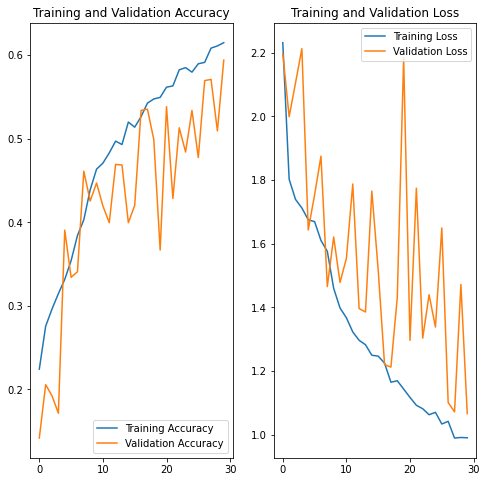

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####   Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Class rebalance has improved model accuracy for train and validation datasets.Accuracy has also increased.

